# Gaussian Distributions in Hyperbolic space
`Drew Wilimitis`

Recent publications have demonstrated how to produce a Gaussian like distribution on hyperbolic space, which is the foundation of probabilistic models. Gaussian Mixture models and Expectation-Maximization (EM) have several advantages over KMeans clustering, such as providing probabilistic or fuzzy classifications and not requiring KMeans assumptions like 'circularity'.   <br>
<br>
I'll first explore the formulation of the pseudo-Gaussian, Wrapped Normal Distribution in the hyperboloid model **[1]**, and then I'll explore another proposal that gives an explicit form of a Gaussian distribution in the Poincaré disk **[2]**. <br>

Finally, I will then attempt to use the hyperbolic gaussian distribution with the Expectation-maximization algorithm to implement a gaussian mixture model in hyperbolic space.

## Standard EM Algorithm with Gaussian Mixture Models

**Input**: Training data  $x_1, \ldots , x_n\in \mathbb{R}^{d}$ and specified number of source components/gaussian clusters $k$:<br>

**Goal**: Perform clustering on input data and return cluster assignments <br>
1. **Initialization step**: Initialize gaussian mean, covariance $(\mu_k , \Sigma_k)$ for each gaussian cluster $\mathcal{G}(\boldsymbol{\mu_k}, \Sigma_k)$ and initialize cluster assignments<br>
2. **E-step**: For each data point $x_i$, and for each cluster label $k$, compute probability $p\left(y_{i}=k | x_{i}, \Theta^{(t)}\right)$ of class assignment <br>
3. **M-step**: Update parameters $\Theta^{(t+1)}$ by computing new means and covariances based on updated class assignment probabilities <br>
4. **Repeat steps 2-3 until stopping criteria** <br>
5. **Return:** cluster labels for all $x_i$ and final parametrized gaussian cluster $\mathcal{G_k}(\boldsymbol{\mu_k}, \Sigma_k)$ for all $k$

## Load libraries and helper functions

In [6]:
# import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('seaborn')
%matplotlib inline
import networkx as nx
import sys
import os

# import modules within repository
sys.path.append('C:\\Users\\dreww\\Desktop\\hyperbolic-learning\\utils') # path to utils folder
sys.path.append('C:\\Users\\dreww\\Desktop\\frechet-mean-hyperboloid')
from manifold import *
from plotting import *
from utils import *

# ignore warnings
import warnings
warnings.filterwarnings('ignore');

# display multiple outputs within a cell
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all";

## Method 1: Wrapped Normal Distribution in the Lorentz Model

The wrapped normal distribution presented in **[1]** has the advantage of offering a fully differentiable probability density function, which is highly advantageous for gradient descent algorithms. This contruction might involve complications, however, with its projections and transformations between spaces. 

**Lorentz Model Background & Definitions** <br>

Lorentz model has simpler closed form geodesics and particularly cleaner expressions for the exponential map and parallel transport. <br>

We have the lorentzian product:
$$
\left\langle\boldsymbol{z}, \boldsymbol{z}^{\prime}\right\rangle_{\mathcal{L}}=-z_{0} z_{0}^{\prime}+\sum_{i=1}^{n} z_{i} z_{i}^{\prime}
$$ <br>
which we use to define the hyperboloid/Lorentz model as the following set:

$$
\mathbb{H}^{n}=\left\{\boldsymbol{z} \in \mathbb{R}^{n+1}:\langle\boldsymbol{z}, \boldsymbol{z}\rangle_{\mathcal{L}}=-1, \quad z_{0}>0\right\}
$$ <br>

The lorentzian distance is given by: $$
d_{\ell}\left(\boldsymbol{z}, \boldsymbol{z}^{\prime}\right)=\operatorname{arccosh}\left(-\left\langle\boldsymbol{z}, \boldsymbol{z}^{\prime}\right\rangle_{\mathcal{L}}\right)
$$ <br>

and finally we set this vector as the origin: 
$$
\boldsymbol{\mu}_{0}=[1,0,0, \ldots .0] \in \mathbb{H}^{n} \subset \mathbb{R}^{n+1}
$$

**Parallel transport** <br>

Parallel transport takes some $v$ to $u$ by mapping between tangent spaces $T_{\nu} \mathbb{H}^{n}$ to $T_{\mu} \mathbb{H}^{n}$ along the geodesic in a parallel manner<br>
<br>

$$
\mathrm{PT}_{\nu \rightarrow \mu}(\boldsymbol{v})=\boldsymbol{v}+\frac{\langle\boldsymbol{\mu}-\alpha \boldsymbol{\nu}, \boldsymbol{v}\rangle_{\mathcal{L}}}{\alpha+1}(\boldsymbol{\nu}+\boldsymbol{\mu})
$$ where $\alpha=-\langle\boldsymbol{v}, \boldsymbol{\mu}\rangle_{\mathcal{L}}$


**Exponential Map** <br>

The exponential map: $\exp _{\mu}: T_{\mu} \mathbb{H}^{n} \rightarrow \mathbb{H}^{n}$  projects some vector $u$ from a tangent space of the hyperboloid to a vector $z \in \mathbb{H}^{n}$
<br>

$$
z=\exp _{\mu}(\boldsymbol{u})=\cosh \left(\|\boldsymbol{u}\|_{L}\right) \boldsymbol{\mu}+\sinh \left(\|\boldsymbol{u}\|_{L}\right) \frac{\boldsymbol{u}}{\|\boldsymbol{u}\|_{\mathcal{L}}}
$$

___
**Algorithm Outline:** Defining hyperbolic gaussian distribution $\mathcal{G}(\boldsymbol{\mu}, \Sigma)$ with $\mu \in \mathbb{H}^{n}$ and positive definite $\Sigma .$
___ 

1. Sample a vector ${\boldsymbol{v}^{*}}$ from the Gaussian distribution $\mathcal{N}(\mathbf{0}, \mathbf{\Sigma}) \text { defined over } \mathbb{R}^{n}$
2. Interpret ${\boldsymbol{v}^{*}}$ as an element of $T_{\boldsymbol{\mu}_{0}} \mathbb{H}^{n} \subset \mathbb{R}^{n+1}$ by rewriting
$ {\boldsymbol{v}^{*}} \text { as } \boldsymbol{v}=[0, {\boldsymbol{v}^{*}}]$<br>

3. Parallel transport the vector $\boldsymbol{v} \ $  to  $\ \boldsymbol{u} \in T_{\boldsymbol{\mu}} \mathbb{H}^{n} \subset \mathbb{R}^{n+1}$
along the geodesic from $\mu_{0}$ to $\mu$ <br>

4. Map $u$ to $\mathbb{H}^{n}$ by $\exp _{\mu}$

___

In [46]:
# first get sample from standard multivariate gaussian 
def init_sample(dim = 2):
    mean = np.zeros((dim))
    cov = np.eye(dim)
    v = np.random.multivariate_normal(mean, cov)
    tangent_0 = np.insert(v, 0, 0)
    return tangent_0

# define alternate minkowski/hyperboloid bilinear form
def lorentz_product(u, v):
    return -u[0]*v[0] + np.dot(u[1:], v[1:])

def lorentz_norm(u):
    return np.sqrt(lorentz_product(u,u))

def parallel_transport(base_vec, target_vec, transport_vec):
    """Mapping between tangent spaces, transports vector along geodesic from v to u""" 
    alpha = -lorentz_product(base_vec, target_vec)
    frac = lorentz_product(target_vec - alpha*base_vec, transport_vec) / (alpha+1)
    return transport_vec + frac*(base_vec + target_vec)

def exp_map(u, mu):
    """Given v in tangent space of u, we project v onto the hyperboloid surface""" 
    first = np.cosh(lorentz_norm(u)) * mu 
    last = np.sinh(lorentz_norm(u)) * (u / lorentz_norm(u))
    return first + last

def hyperbolic_sampling(n_samples, mean, covariance, dim=2, poincare=False):
    data = []
    mu_0 = np.array([1, 0, 0])
    for i in range(n_samples):
        init_v = init_sample(dim=dim)
        tangent_u = parallel_transport(base_vec=mu_0, target_vec=mean, transport_vec=init_v)
        data.append(exp_map(tangent_u, mean))
    data = np.array(data)
    if poincare:
        return hyperboloid_pts_to_poincare(data, metric='lorentz')
    else:
        return data

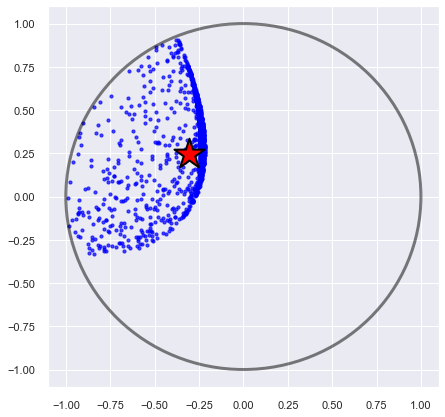

In [47]:
n = 5000
test_mean = poincare_pt_to_hyperboloid(generate_data(1, radius=0.2)[0])
test_cov = np.eye(3)
gaussian_samples = hyperboloid_pts_to_poincare(hyperbolic_sampling(n, test_mean, test_cov**2), metric='lorentz')
gaussian_samples = gaussian_samples[np.linalg.norm(gaussian_samples, axis=1) < 1]

plt.figure(figsize=(7,7))
sns.set()
plt.xlim([-1.1,1.1])
plt.ylim([-1.1,1.1])
ax = plt.gca()
circ = plt.Circle((0, 0), radius=1, edgecolor='black', facecolor='None', linewidth=3, alpha=0.5)
ax.add_patch(circ)
plt.scatter(gaussian_samples[:, 0], gaussian_samples[:, 1], c='blue', s=10, alpha=0.7)
plt.scatter(hyperboloid_pt_to_poincare(test_mean)[0], hyperboloid_pt_to_poincare(test_mean)[1],
            s=1000, c='red', edgecolor='black', marker='*', linewidth=2)
plt.show();

## Method 2: Explicitly defined Gaussian in the Poincare Disk

A closed form expression for the gaussian density is highly advantageous, however, this density is not fully differentiable and might be significantly harder to sample from this gaussian density in hyperbolic space.

$$
p(\mathbf{x} | \boldsymbol{\mu}, \boldsymbol{\sigma})=\frac{1}{Z(\boldsymbol{\sigma})} e^{-\frac{d^{2}(\boldsymbol{x}, \boldsymbol{\mu})}{2 \sigma^{2}}} \quad Z(\boldsymbol{\sigma})=2 \pi \sqrt{\frac{\pi}{2}} \boldsymbol{\sigma} e^{\frac{\sigma^{2}}{2}} \operatorname{erf}\left(\frac{\boldsymbol{\sigma}}{\sqrt{2}}\right)
$$ <br>
Error function term given by: $$
\begin{aligned}
\operatorname{erf}(x) &=\frac{1}{\sqrt{\pi}} \int_{-x}^{x} e^{-t^{2}} d t \\
&=\frac{2}{\sqrt{\pi}} \int_{0}^{x} e^{-t^{2}} d t
\end{aligned}
$$

The density is somewhat similar to the Euclidean case, but here the distance becomes the Poincaré distance, and the parameters are the Frechet mean $\boldsymbol{\mu}$, and the dispersion $\sigma > 0$.

In [ ]:
def uniform_sample_hyperboloid_disc(max_distance, centre=None):
    """
    Return a sample drawn uniformly at random from the disc of
    radius `max_distance` on the hyperboloid.
    NOTE: formula is specific to the case of local-dimension 2.
    """
    rank = 2
    tangent = np.random.randn(rank + 1)
    tangent[rank] = 0
    tangent /= np.sqrt(tangent.dot(tangent))
    # we use inversion sampling: invert the CDF, apply result to uniform random samples from [0,1]
    p = np.random.uniform()
    tangent *= np.arccosh(1 + p * (np.cosh(max_distance) - 1))
    basept = coordinate_vector(rank, rank + 1)
    if centre is None:
        centre = basept
    else:
        centre_log = logarithm(basept, centre)
        tangent = geodesic_parallel_transport(basept, centre_log, tangent)
    return exponential(centre, tangent)

## References
___

**[1]** Nagano, Y., Yamaguchi, S., Fujita, Y., & Koyama, M. (2019). A Differentiable Gaussian-like Distribution on Hyperbolic Space for Gradient-Based Learning. ArXiv, abs/1902.02992. <br>

**[2]** Ovinnikov, Ivan. “Poincaré Wasserstein Autoencoder.” ArXiv abs/1901.01427 (2019): n. pag.